In [1]:
from types import MethodType

import numpy as np
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Softmax

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from livelossplot import PlotLosses
from livelossplot.tf_keras import PlotLossesCallback
from matplotlib import pyplot as plt

np.random.seed(7)

# Prepare data

In [2]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

enc = OneHotEncoder(sparse=False)
Y = enc.fit_transform(y[:, np.newaxis])

X_temp, X_test, Y_temp, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=2)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.25, random_state=2)

input_dim = X.shape[1]
output_dim = Y.shape[1]

/home/aidar/PycharmProjects/untitled/venv/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


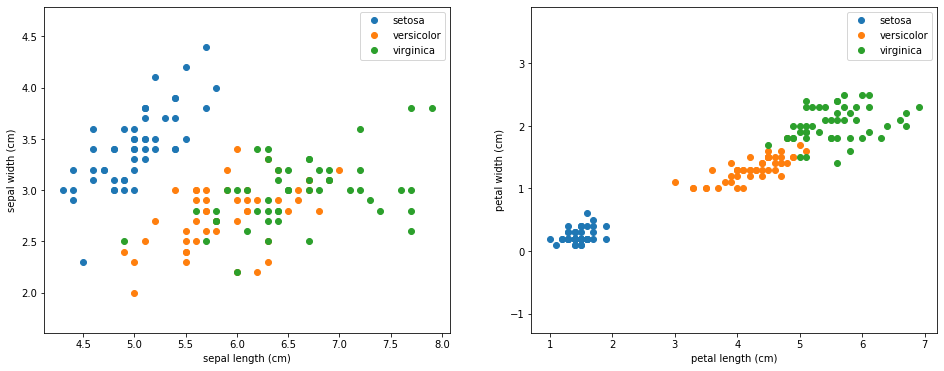

In [3]:
plt.figure(figsize=(16, 6))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    for target, target_name in enumerate(names):
        X_plot = X[y == target]
        plt.plot(X_plot[:, 2*i], X_plot[:, 2*i + 1], linestyle='none', marker='o', label=target_name)
    plt.xlabel(feature_names[2*i])
    plt.ylabel(feature_names[2*i + 1])
    plt.axis('equal')
    plt.legend()

plt.show()

# Define model

In [4]:
def create_model():
    model = Sequential()
    model.add(Dense(17, input_dim=input_dim, activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    return model

In [5]:
create_model().summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 17)                85        
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 126       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 24        
Total params: 235
Trainable params: 235
Non-trainable params: 0
_________________________________________________________________


# Simulated annealing optimizer

In [6]:
def prepare_model(model, init_std):
    model.compile(loss='categorical_crossentropy', metrics=["accuracy"])
    for layer in model.layers:
        shape = layer.get_weights()[0].shape
        layer.set_weights([np.random.normal(0, init_std, size=shape), np.zeros(shape[1])])

    def get_weights(self):
        return [layer.get_weights()[0] for layer in self.layers]

    def set_weights(model, weights):
        for layer, w in zip(model.layers, weights):
            layer.set_weights([w, np.zeros(w.shape[1])])

    def generate_weights(model, std):
        for layer in model.layers:
            weights = layer.get_weights()[0]
            weights += np.random.normal(0, std, weights.shape)
            layer.set_weights([weights, np.zeros(weights.shape[1])])
    
    model.get_weights = MethodType(get_weights, model)
    model.set_weights = MethodType(set_weights, model)
    model.generate_weights = MethodType(generate_weights, model)

def accepted(new_loss, last_loss, T):
    alpha = np.exp(-new_loss / T) / np.exp(-last_loss / T)
    return np.random.uniform() <= alpha

def simulated_annealing(T=5, iterations=200, a=0.95, init_std=0.5, std=0.1, draw_plots=True):
    model = create_model()
    prepare_model(model, init_std)
    
    liveplot = PlotLosses(max_epoch=iterations)
    
    last_weights = model.get_weights()
    last_loss, last_acc = model.evaluate(X_train, Y_train, verbose=False)
    for i in range(iterations):
        model.generate_weights(std)
        loss, acc = model.evaluate(X_train, Y_train, verbose=False)
        
        if not accepted(loss, last_loss, T):
            model.set_weights(last_weights)
            loss, acc = last_loss, last_acc 

        last_weights = model.get_weights()
        last_loss, last_acc = loss, acc
        val_loss, val_acc = model.evaluate(X_val, Y_val, verbose=False)
        T *= a
        
        liveplot.update({
            'loss': loss,
            'val_loss': val_loss,
            'accuracy': acc,
            'val_accuracy': val_acc,
        })
        if draw_plots and i % (iterations / 20) == 0:
            liveplot.draw()
    loss, acc = model.evaluate(X_test, Y_test, verbose=False)
    print(f'\nTest loss: {loss:.4f}\nTest accuracy: {100 * acc:.1f}%\n')
    return model

In [7]:
%%time
model = simulated_annealing(T=5, iterations=700, a=0.99, draw_plots=False)


Test loss: 0.5390
Test accuracy: 86.7%

CPU times: user 10.9 s, sys: 494 ms, total: 11.4 s
Wall time: 9.66 s


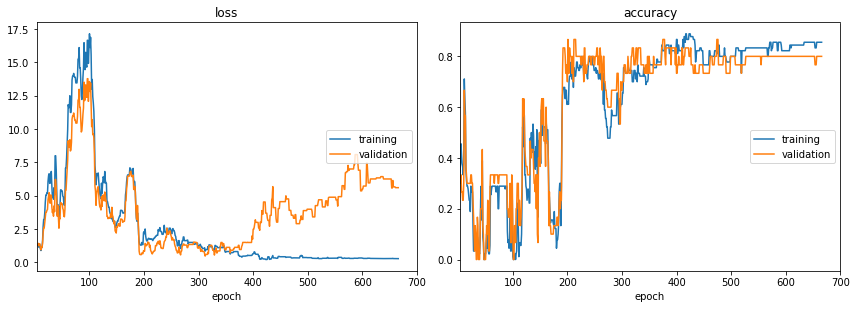

loss:
training   (min:    0.207, max:   17.131, cur:    0.272)
validation (min:    0.464, max:   13.765, cur:    5.594)

accuracy:
training   (min:    0.000, max:    0.889, cur:    0.856)
validation (min:    0.000, max:    0.867, cur:    0.800)

Test loss: 2.1830
Test accuracy: 83.3%



In [8]:
model = simulated_annealing(T=5, iterations=700, a=0.99)

In [9]:
%%time
model = simulated_annealing(T=100, iterations=100, a=0.9, draw_plots=False)


Test loss: 0.5017
Test accuracy: 83.3%

CPU times: user 2.15 s, sys: 121 ms, total: 2.27 s
Wall time: 1.95 s


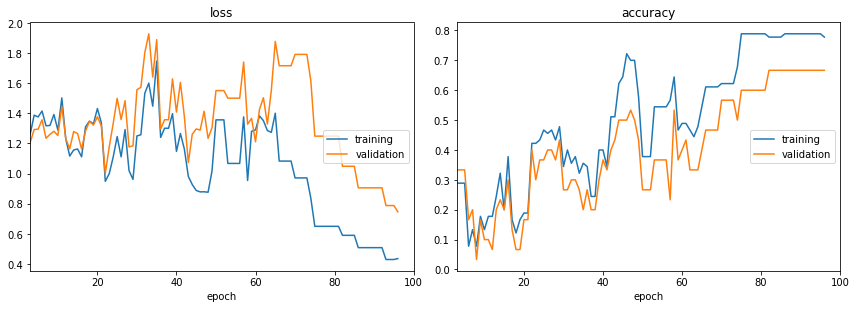

loss:
training   (min:    0.430, max:    1.747, cur:    0.437)
validation (min:    0.747, max:    1.928, cur:    0.747)

accuracy:
training   (min:    0.078, max:    0.789, cur:    0.778)
validation (min:    0.033, max:    0.667, cur:    0.667)

Test loss: 0.8550
Test accuracy: 56.7%



In [10]:
model = simulated_annealing(T=100, iterations=100, a=0.9)

In [11]:
%%time
model = simulated_annealing(T=1e8, iterations=60, a=0.6, draw_plots=False)


Test loss: 3.5288
Test accuracy: 23.3%

CPU times: user 1.16 s, sys: 38.7 ms, total: 1.2 s
Wall time: 1.01 s


/home/aidar/PycharmProjects/untitled/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


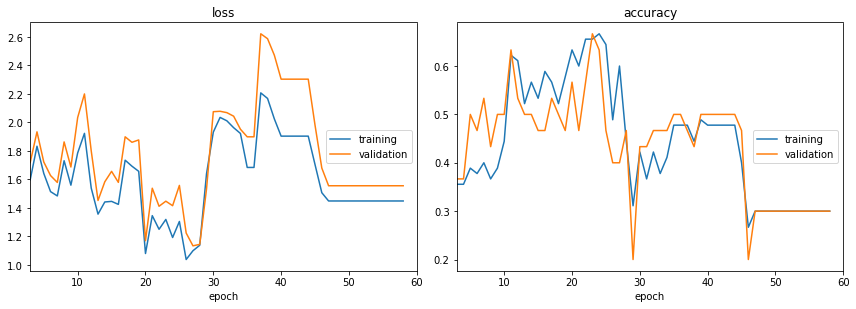

loss:
training   (min:    1.038, max:    2.207, cur:    1.449)
validation (min:    1.134, max:    2.622, cur:    1.556)

accuracy:
training   (min:    0.267, max:    0.667, cur:    0.300)
validation (min:    0.200, max:    0.667, cur:    0.300)

Test loss: 1.3687
Test accuracy: 30.0%



In [12]:
model = simulated_annealing(T=1e8, iterations=60, a=0.6)

# Other optimizers

In [13]:
def fit_evaluate_optimizer(optimizer, draw_plots=True):
    model = create_model()
    model.compile(optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
    model.fit(
        X_train,
        Y_train,
        epochs=100,
        validation_data=(X_val, Y_val),
        verbose=False,
        callbacks=[PlotLossesCallback()] if draw_plots else []
    )
    loss, acc = model.evaluate(X_test, Y_test, verbose=False)
    print(f'\nTest loss: {loss:.4f}, Test accuracy: {100 * acc:.1f}%\n')
    return model

In [14]:
%%time
model = fit_evaluate_optimizer('sgd', draw_plots=False)


Test loss: 0.4013, Test accuracy: 83.3%

CPU times: user 1.2 s, sys: 79.9 ms, total: 1.28 s
Wall time: 1.03 s


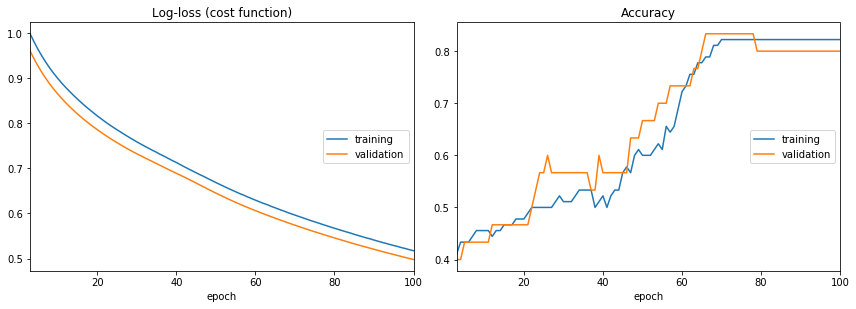

Log-loss (cost function):
training   (min:    0.518, max:    1.039, cur:    0.518)
validation (min:    0.498, max:    1.000, cur:    0.498)

Accuracy:
training   (min:    0.389, max:    0.822, cur:    0.822)
validation (min:    0.400, max:    0.833, cur:    0.800)

Test loss: 0.4304, Test accuracy: 83.3%



In [15]:
model = fit_evaluate_optimizer('sgd')

In [16]:
%%time
model = fit_evaluate_optimizer('adam', draw_plots=False)


Test loss: 0.2297, Test accuracy: 90.0%

CPU times: user 1.78 s, sys: 86.8 ms, total: 1.86 s
Wall time: 1.5 s


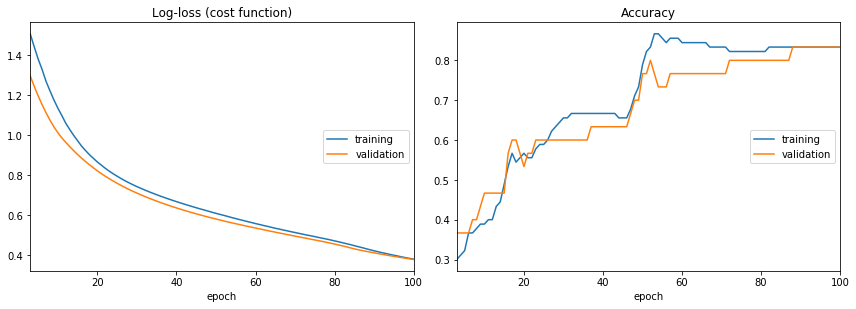

Log-loss (cost function):
training   (min:    0.380, max:    1.646, cur:    0.380)
validation (min:    0.378, max:    1.407, cur:    0.378)

Accuracy:
training   (min:    0.300, max:    0.867, cur:    0.833)
validation (min:    0.367, max:    0.833, cur:    0.833)

Test loss: 0.3227, Test accuracy: 86.7%



In [17]:
model = fit_evaluate_optimizer('adam')